# Lab4: Kmeans

---

## 1 $K-means$ principle
### 1.1 算法概述
k-means是基于划分的动态聚类算法，通过相似度的计算将样本划分为对应类，同时依靠样本均值来计算聚类中心，通过迭代来遍历可能的簇划分，利用贪心策略求得近似解，容易陷入局部最优。本质上是"物以类聚"。

### 1.2 算法步骤
1. 确定分类数目$k$
2. 初始化聚类中心$\mu_1，\mu_2，\mu_3...\mu_k$
3. 计算样本到各个聚类中心的距离，选择最小距离（最高相似度）给样本分类
4. 使用类中样本均值重新计算聚类中心
5. 重复step3，step4直到重新计算距离并分类后，没有样本的类别发生改变

### 1.3 关键问题
#### 1.3.1 k取值问题
初始设定分类数目k会极大程度影响分类效果。k过小导致模型欠拟合，k过大则有可能类别过密。因此确定一个合适的k值很重要。
通过观察可以粗略确定可视化后图片像素点聚类分割的效果。为了定量确定k的聚类效果，可以采用以下两种评估方式：

- SSE：聚类内部相似度，误差的平方和
  $$ SSE = \sum_{i=1}^k\sum_{x\in C_i}||x-\mu_i||^2 $$
  

- 轮廓系数（Silhouette Coefficient）
  $$ s = \frac{1}{n}\sum \frac{b-a}{max(a,b)} $$
  $a$表示向量到所有它属于的簇中其它点的距离，即簇内不相似度；$b$表示向量到距离最近一簇内的所有点的平均距离，即簇间不相似度

#### 1.3.2 聚类中心初始化问题
聚类的最终效果严重依赖于初始聚类的中心点的选择。如果选择不恰当，将会非常容易陷入局部最优解。因此，此处使用$Kmeans++$手段优化。

$Kmeans++$的基本思想是初始的聚类中心距离越远越好。算法步骤如下：

1. 从数据集$\chi$中随机选择一个样本点作为第一个聚类中心点$C_1$
2. 计算$\chi$中剩余样本点$x$距离当前已有聚类中心点的最短距离$D(x)$和这个样本点被选为聚类中心的概率$P(x) = \frac{D(x)^2}{\sum_{x\in \chi}D(x)^2}$
3. 选择样本点作为下一个聚类中心，重复step2直到选择了k个聚类中心


---

## 2 核心代码

代码使用的库如下

In [17]:
from sklearn import preprocessing
import PIL.Image as Image
import numpy as np
import sys
import pandas as pd
import random
import matplotlib.pyplot as plt

random.seed(53)

### 2.1 图像处理

图片为24位图像，每个像素点由三原色即RGB组成，每种颜色取值0~255，因此像素点的颜色值由3个通道表示。把图片转化成可以处理的数据，返回所有的像素点的三通道序列。

为什么要令矩阵中元素值介于0~1之间？对输入图像进行归一化操作。将0~255数值映射到0~1中，使得数据处理更加统一方便，便于模型快速收敛。

In [18]:
def load_pic(file_path):
    '''
    Generate numpy matrix according to input file path.
    Return values include list, pic_width & pic_height. 
    '''
    with open(file_path,'rb') as f: # open picture file
        data = []
        position = []
        image = Image.open(f)   
        width, height = image.size
        for x in range(width):
            for y in range(height):
                r,g,b = image.getpixel((x,y)) # get rgb at(x,y)
                position.append((x,y))
                data.append([r/255.0,g/255.0,b/255.0]) # normalize
    print("Picuture successfully loaded.")
    return data, width, height, position

### 2.2 kmeans
计算距离的方式采用欧氏距离。

In [19]:
def cal_dist(dataset, centroids):
    '''Calculate Euclidean distance '''
    dist_list = []
    for data in dataset:
        # fill the data k times to minus centroids
        diff = np.tile(data,(len(centroids),1))-centroids
        dist_square = np.sum(np.square(diff),axis=1)
        dist_list.append(dist_square)
    return np.array(dist_list)

In [20]:
def cal_centroids(dataset,centroids):
    '''calculate new centroids'''
    dist_list = cal_dist(dataset,centroids)
    # calculate the centroids index of min distance
    min_idx = np.argmin(dist_list,axis=1) 
    new_centroids = pd.DataFrame(dataset).groupby(min_idx).mean().values

    # calculate the changes
    changes = new_centroids-centroids

    return changes,new_centroids

In [27]:
random.sample([[1,2,3],[2,3,4],[3,4,5]],1)

[[1, 2, 3]]

In [34]:
def random_kmeans_plus(X,k):
    '''use kmeans++ to select original centroids'''
    copy_data = X.copy()  # clone the original data 
    centroids = []
    c1 = random.sample(copy_data,1)[0] # choose first center randomly
    centroids.append(c1)
    copy_data.remove(c1)
    k -= 1

    while k > 0:
        k -= 1
        min_d = []
        for sample in copy_data:
            min_dist = sys.maxsize
            for c in centroids:
                d = np.sum(np.square(np.array(c)-np.array(sample)))
                if d < min_dist:
                    min_dist = d
            min_d.append(min_dist)
        prob = np.array(min_d)/np.sum(np.array(min_d))
        c2 = random.choices(copy_data,weights=prob)[0]
        centroids.append(c2)
        copy_data.remove(c2)
    
    return centroids


迭代停止条件设定为：
- 所有聚类中心不再改变
- 迭代达到50次

In [22]:
def Kmeans(X,k, position, random_type = None):
    if random_type == None:
        centroids = random.sample(X,k) # randomly sample k centroids
    elif random_type == "kmeans++":
        centroids = random_kmeans_plus(X,k) # use kmeans++


    changes, centroids = cal_centroids(X,centroids)
    # continue updating centroids until changes equals zero
    # or the iteration has been done 50 times
    epoch = 1
    while np.any(changes != 0) and epoch < 50:
        changes, centroids = cal_centroids(X,centroids)
        print("Finished: k=%(k)i, epoch=%(e)i"% {"k":k,"e":epoch})
        epoch += 1

    # calculate clusters according to centroids
    cluster = []
    rgb_cluster = [] # calculate rgb clusters to estimate results(SSE)
    for i in range(k):
        cluster.append([])
        rgb_cluster.append([])
    dist_list = cal_dist(X,centroids)
    min_idx = np.argmin(dist_list,axis=1)
    for i,j in enumerate(min_idx):
        cluster[j].append(position[i])
        rgb_cluster[j].append(X[i])

    print("Finish Kmeans: K=%i"% k)
    return centroids,cluster,rgb_cluster

### 2.3 可视化结果

In [23]:
def draw_result(pic_path,results,width,height):
    plt.title("Picture Segment using Kmeans") # title for the pic
    plt.subplot(231) # place sub plot at first section(total 2 rows & 3 columns)
    plt.title("Origin")
    plt.imshow(Image.open(pic_path)) # display original pic
    plt.axis('off') # shut down the axis
    plt.xticks([])
    plt.yticks([]) # shut down x,y values

    colors = [(0, 0, 255),(255, 0, 0),(0, 255, 0),(60, 0, 220),(167, 255, 167),(142,133,242)]
    
    n = 2
    for res in results:
        new_pic = Image.new("RGB",(width,height))
        for i in range(len(res[0])):
            for j in res[1][i]:
                new_pic.putpixel(j,colors[i])
        plt.subplot(230+n)
        plt.title("K=%i"% n)
        plt.imshow(new_pic)
        plt.axis('off')
        plt.xticks([])
        plt.yticks([])
        n += 1
    
    plt.show()
    

Picuture successfully loaded.
Finished: k=2, epoch=1
Finished: k=2, epoch=2
Finished: k=2, epoch=3
Finished: k=2, epoch=4
Finished: k=2, epoch=5
Finished: k=2, epoch=6
Finished: k=2, epoch=7
Finished: k=2, epoch=8
Finished: k=2, epoch=9
Finished: k=2, epoch=10
Finished: k=2, epoch=11
Finished: k=2, epoch=12
Finished: k=2, epoch=13
Finished: k=2, epoch=14
Finished: k=2, epoch=15
Finished: k=2, epoch=16
Finished: k=2, epoch=17
Finished: k=2, epoch=18
Finished: k=2, epoch=19
Finished: k=2, epoch=20
Finished: k=2, epoch=21
Finished: k=2, epoch=22
Finished: k=2, epoch=23
Finished: k=2, epoch=24
Finished: k=2, epoch=25
Finished: k=2, epoch=26
Finished: k=2, epoch=27
Finished: k=2, epoch=28
Finished: k=2, epoch=29
Finished: k=2, epoch=30
Finished: k=2, epoch=31
Finish Kmeans: K=2
Finished: k=3, epoch=1
Finished: k=3, epoch=2
Finished: k=3, epoch=3
Finished: k=3, epoch=4
Finished: k=3, epoch=5
Finished: k=3, epoch=6
Finished: k=3, epoch=7
Finished: k=3, epoch=8
Finished: k=3, epoch=9
Finished:

C:\Users\A.R.L\AppData\Local\Temp\ipykernel_964\3462776361.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(231)


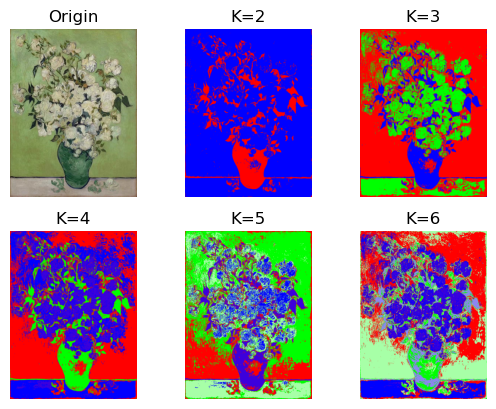

In [24]:
path = "./flowers.jpg"
pic_data, width, height, position = load_pic(path)

res = []
for k in range(2,7):
    centroids, cluster, rgb_cluster = Kmeans(pic_data,k,position)
    res.append((centroids,cluster,rgb_cluster))

draw_result(path,res,width,height)

---

## 3 测试评估

瞪眼法可知：k=3和k=4时拟合效果相对较好。相似点划分较为清晰，能较好的区分物体前景和背景。

### 3.1 使用Kmeans++算法改进



Finished: k=2, epoch=1
Finished: k=2, epoch=2
Finished: k=2, epoch=3
Finished: k=2, epoch=4
Finished: k=2, epoch=5
Finished: k=2, epoch=6
Finished: k=2, epoch=7
Finished: k=2, epoch=8
Finished: k=2, epoch=9
Finished: k=2, epoch=10
Finished: k=2, epoch=11
Finish Kmeans: K=2
Finished: k=3, epoch=1
Finished: k=3, epoch=2
Finished: k=3, epoch=3
Finished: k=3, epoch=4
Finished: k=3, epoch=5
Finished: k=3, epoch=6
Finished: k=3, epoch=7
Finished: k=3, epoch=8
Finished: k=3, epoch=9
Finished: k=3, epoch=10
Finished: k=3, epoch=11
Finished: k=3, epoch=12
Finished: k=3, epoch=13
Finished: k=3, epoch=14
Finished: k=3, epoch=15
Finished: k=3, epoch=16
Finished: k=3, epoch=17
Finished: k=3, epoch=18
Finished: k=3, epoch=19
Finished: k=3, epoch=20
Finished: k=3, epoch=21
Finish Kmeans: K=3
Finished: k=4, epoch=1
Finished: k=4, epoch=2
Finished: k=4, epoch=3
Finished: k=4, epoch=4
Finished: k=4, epoch=5
Finished: k=4, epoch=6
Finished: k=4, epoch=7
Finished: k=4, epoch=8
Finished: k=4, epoch=9
Finis

C:\Users\A.R.L\AppData\Local\Temp\ipykernel_964\3462776361.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(231)


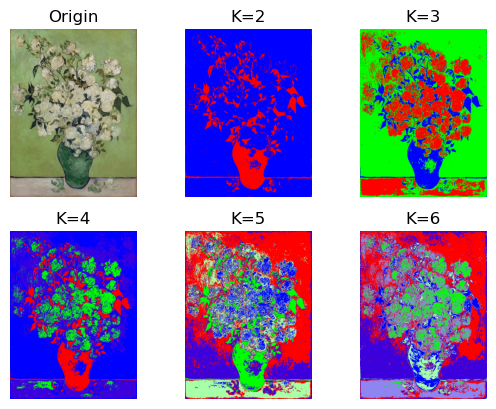

In [35]:
res_plus = []
for k in range(2,7):
    centroids, cluster, rgb_cluster = Kmeans(pic_data,k,position,random_type="kmeans++")
    res_plus.append((centroids,cluster,rgb_cluster))

draw_result(path,res_plus,width,height)

### 3.2 使用SSE定量评估聚类效果

In [36]:
def sse(centroids,cluster):
    '''calculate the average error of each cluster'''
    sse = 0
    for i in range(len(centroids)):
        for v in cluster[i]:
            sse += np.sum(np.square(v-centroids[i]))
    return sse / len(centroids)

In [37]:
print("Evaluating Kmeans...")
for i in range(len(res)):
    print("K=%(k)i: SSE=%(sse)f"% {"k":i+2,"sse":sse(res[i][0],res[i][2])})
print("Evaluating Kmeans++...")
for i in range(len(res_plus)):
    print("K=%(k)i: SSE=%(sse)f"% {"k":i+2,"sse":sse(res_plus[i][0],res_plus[i][2])})

Evaluating Kmeans...
K=2: SSE=9237.908409
K=3: SSE=2785.742855
K=4: SSE=1489.653884
K=5: SSE=933.352696
K=6: SSE=602.181076
Evaluating Kmeans++...
K=2: SSE=9237.908409
K=3: SSE=2785.742855
K=4: SSE=1489.661140
K=5: SSE=933.352696
K=6: SSE=602.192766


综上可见，选择k=3或k=4是较好选择。从图中呈现的效果来看，使用kmeans++算法处理后的图像比未使用的图像更加清晰，
边缘分割效果更好，可以显著观测到kmeans++的改进效果。

---

## 4 参考资料

1. https://blog.csdn.net/qq_30759585/article/details/106269933
2. https://zhuanlan.zhihu.com/p/608317023
3. https://blog.csdn.net/qq_41498261/article/details/100727309
4. https://blog.csdn.net/qq_43741312/article/details/97128745